In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from collections import defaultdict

from Components.ConditionalNormalDistribution import ConditionalNormalDistribution
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelExponential import ModelExponential
from Models.ModelSinCos import ModelSinCos
from Models.ModelLogistic import ModelLogistic
from Models.ModelSigmoid import ModelSigmoid
from Composition.SequentialSystem import SequentialSystem
from SearchAlgorithm.skeleton import BO_skeleton, BO_graph, BO_graph_local_loss

from GraphDecomposition.DirectedFunctionalGraph import DirectedFunctionalGraph
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelSinCos import ModelSinCos
from Models.ModelConstant import ModelConstant
from Models.ModelWeightedSum import ModelWeightedSum
from Models.ModelExponential import ModelExponential

%load_ext autoreload
%autoreload 2
from GraphDecomposition.Heuristic import *
from helper import *
from Plotting.HeatMapLossFunction import *



C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ground truth param

ground_truth_param = {1 : np.array([0.7, 1.1, -0.5]), 2: np.array([1.3, -.7]), 8: np.array([-0.2, -0.2]), 9: np.array([-0.5, 0.5]), 10: np.array([-0.2, 0.1]), 11: np.array([-0.3, 0.3, 0.2]),
                      12: np.array([0.1, 0.1]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([1.1, -0.5]), "Blackbox5":np.array([0.7, -0.5]),
                      "Blackbox6": np.array([0.7, 1.1]), 7: np.array([0.7, -0.5])}

# single input, single output
def get_data(component : Model, input_range_lower, input_range_upper, ground_truth_param, noisy=True):
    # ground truth for training
    component = copy.deepcopy(component)
    component.set_params(ground_truth_param)

    X_local = torch.tensor(np.random.uniform(input_range_lower, input_range_upper, size=100))
    y_local = component.forward(X_local, noisy=noisy)  # labeling effort of A

    return X_local, y_local

# multi input, single output (default is input size 2)
def get_data_tree(component : Model, input_range_lower, input_range_upper, ground_truth_param, inputs=2):
    # ground truth for training
    component = copy.deepcopy(component)
    component.set_params(ground_truth_param)

    X_local = torch.tensor(np.random.uniform(input_range_lower, input_range_upper, size=(inputs,100)))
    y_local = component.forward(X_local, noisy=True)  # labeling effort of A

    return X_local, y_local


In [35]:
from Models.ModelMNIST import ModelMNIST
from mnist.MNISTLoader import *
from helper import *

ground_truth_param_mnist = {1 : np.array([0.7, 1.1, -0.5]), 2: np.array([1.3, -.7]), 12: np.array([0.1, 0.1]), "Blackbox3":np.array([1.2, 0.8]), 4:np.array([-0.3, 0.5])}

def create_mnist_system():
    np.random.seed = 10
    dg_nn = DirectedFunctionalGraph()
    # white box components
    local_mnist,system_mnist = generate_data_loader(num_datapts=100,batch_size=100,label_int=5)
    dg_nn.add_node("nn_1", component=ModelMNIST(local_train_loader=local_mnist, system_train_loader=system_mnist, output_size=2))

    dg_nn.add_node(2, component=ModelWeightedSum())
    x,y = get_data_tree(dg_nn.nodes[2]["component"], 0, 5, ground_truth_param_mnist[2])
    dg_nn.nodes[2]["component"].attach_local_data(x,y)
    
    dg_nn.add_node(4, component=ModelSinCos())
    x,y = get_data(dg_nn.nodes[4]["component"], 0, 5, ground_truth_param_mnist[4])
    dg_nn.nodes[4]["component"].attach_local_data(x,y)

    dg_nn.add_node("Blackbox3", component=ModelWeightedSum())
    dg_nn.add_edge(("nn_1", 2), "Blackbox3")
    dg_nn.add_edge("Blackbox3", 4)

    x,y = get_end_to_end_nn_data(dg_nn, ground_truth_param_mnist)

    dg_nn.system_x = x
    dg_nn.system_y = y
    dg_nn.get_system_loss()
    return dg_nn



[1. 0. 0. ... 1. 0. 0.]
adding edge from nn_1 to Blackbox3
adding edge from 2 to Blackbox3
setting:  [ 1.3 -0.7]
setting:  [-0.3  0.5]
setting:  [1.2 0.8]


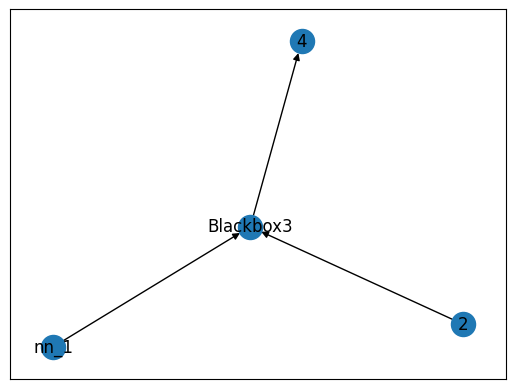

In [37]:
dg_nn = create_mnist_system()
nx.draw_networkx(dg_nn)
plt.show()

[0.7756085043896499, -0.17785501985622232]
[0.5380686811173017, -0.8770814460098726]
final system loss:  tensor(0.1012, dtype=torch.float64)


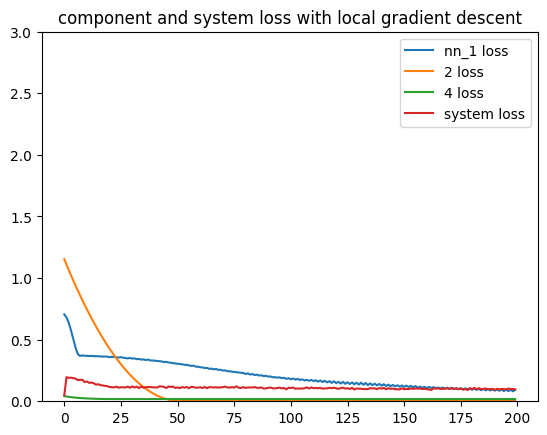

In [38]:
#grad descent
dg_nn.random_initialize_param()

lower_bound_local_loss = show_system_loss_from_grad_descent(dg_nn, itr=200, plot=True)
lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]

In [32]:
dg_nn.get_all_params()

({'nn_1': [None],
  2: [0.005315374175027587, -0.7868676818029563],
  4: [0.04706416461274143]},
 [None, 0.005315374175027587, -0.7868676818029563, 0.04706416461274143])

In [31]:
dg_nn.random_initialize_param()

[0.005315374175027587, -0.7868676818029563]
[0.04706416461274143]


[-0.7111850640261856, -0.9959047430596366]
[-0.22976061009986415, 0.46401963571680693]
BO iteration:  0
Current best objective:  -10000
loss to look for:  tensor([3.0410e-01, 1.6294e+01, 2.4357e-03], dtype=torch.float64)
[0.569276672985322, -0.44798443980859304]
[-0.2726969501700396, -0.16762771700031087]
[-0.903999370723598, 0.481922098507241]
[-0.40558703204355195, -0.07238425590477293]
[-0.8176024655416188, -0.8082589172996983]
[-0.08641905791401472, 0.5072948112079563]
[0.3635297386281984, -0.5015289529267384]
[-0.007162223016462299, -0.07439998171810269]
[-0.7582459480556119, -0.1668346663009035]
[-0.44703144540297823, 0.041190534436609694]
number to sample from all params:  5
[(1, 2, 1), (2, 2, 0), (2, 1, 2), (2, 1, 0), (2, 0, 0)]


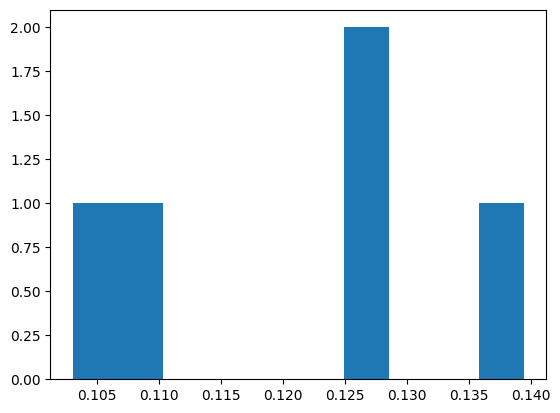

candidate: tensor([[0.4290, 0.0087, 0.0269]], dtype=torch.float64)
BO iteration:  1
Current best objective:  tensor(-0.1364, dtype=torch.float64)
loss to look for:  tensor([0.4290, 0.0087, 0.0269], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[0.2311617180964749, -0.7752978877826522]
[0.6639850534481531, 0.032364934488378294]
[-0.7502877051587762, 0.36329304576664967]
[-0.4739913840213925, -0.6395369583943182]
[0.7283644701046752, -0.15670802902372039]
[0.8469977711633256, 0.3800191888233899]
[-0.07109139075622406, -0.15427622558891452]
[-0.13619404228458998, -0.9491059247037079]
[-0.29827952044059347, 0.7419776791091168]
[-0.41481934515262675, 0.9338117707972122]
number to sample from all params:  5
[(1, 2, 1), (1, 0, 2), (2, 2, 2), (0, 2, 2), (1, 1, 2)]


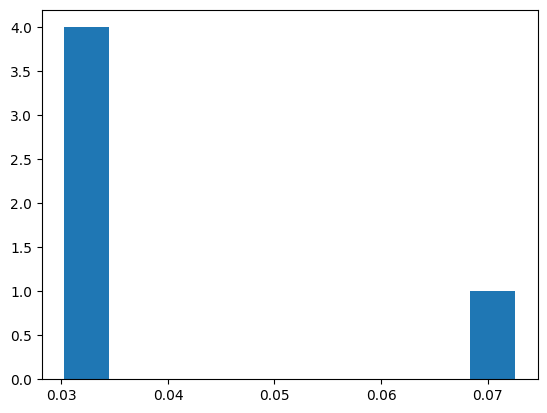

candidate: tensor([[0.2016, 0.0043, 0.0580]], dtype=torch.float64)
BO iteration:  2
Current best objective:  tensor(-0.0307, dtype=torch.float64)
loss to look for:  tensor([0.2016, 0.0043, 0.0580], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[0.14108157397956145, 0.7562024334460777]
[-0.9652292509429998, -0.5353920025770087]
[0.5120975658232465, -0.38094184365534445]
[0.921243577231514, 0.28059013829300006]
[-0.42427695981421976, 0.8822510247602242]
[0.589923741589033, -0.3086267416029642]
[0.8021504161984176, -0.27898014429248996]
[0.1063131044941068, 0.36461236980168366]
[0.20265221199422578, -0.16250727412133048]
[-0.303661074997563, -0.10719512146001531]
number to sample from all params:  5
[(1, 0, 0), (1, 1, 1), (2, 2, 0), (2, 1, 2), (1, 0, 2)]


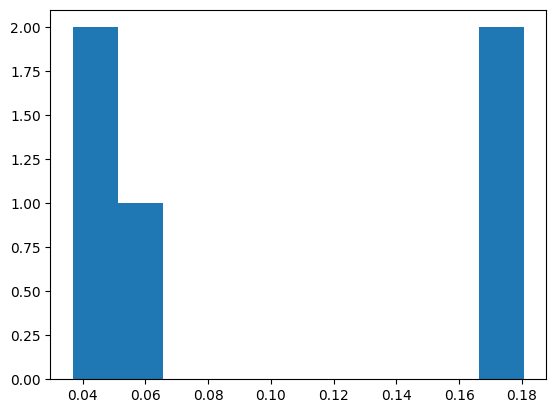

candidate: tensor([[0.4633, 0.0110, 0.0179]], dtype=torch.float64)
BO iteration:  3
Current best objective:  tensor(-0.0307, dtype=torch.float64)
loss to look for:  tensor([0.4633, 0.0110, 0.0179], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[0.40762985014893993, -0.04050644625988986]
[-0.7505463110813371, -0.7228592251334913]
[-0.6323450305685356, 0.958307293207443]
[0.002941867099157447, -0.7137208184920765]
[0.2885211867660382, -0.408791845352932]
[0.0032279587597929815, 0.5351284937025254]
[0.3197990256956167, 0.6150879866126013]
[-0.5163487371209499, -0.2925708315853752]
[0.5176384025099277, 0.18220974231975196]
[0.4494849785735944, -0.6300035131604629]
number to sample from all params:  5
[(1, 1, 2), (0, 0, 2), (1, 1, 0), (0, 2, 0), (2, 0, 2)]


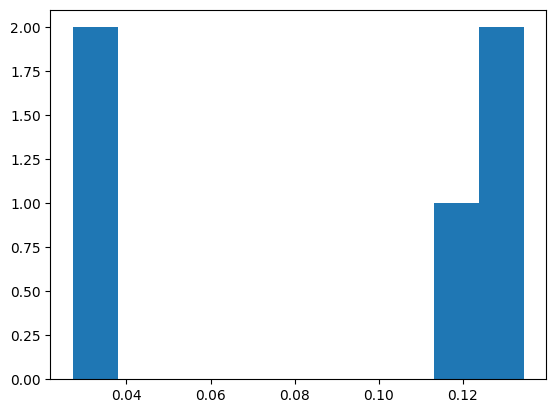

candidate: tensor([[0.4633, 0.0110, 0.0179]], dtype=torch.float64)
BO iteration:  4
Current best objective:  tensor(-0.0307, dtype=torch.float64)
loss to look for:  tensor([0.4633, 0.0110, 0.0179], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[-0.6221447427475684, 0.838358207872623]
[-0.9066311488898959, 0.7349515968503662]
[-0.15398695118096972, 0.1852530969265449]
[-0.7378670085312118, 0.8663987977607921]
[-0.21844281159122003, 0.8398226929102368]
[-0.5157255955131099, 0.24497984715808996]
[0.2710766587800195, -0.8118200186269713]
[0.6074583496070138, 0.8744837022824032]
[0.02767288219837649, 0.370777045945508]
[0.559873947327624, 0.5037802617864173]
number to sample from all params:  5
[(0, 0, 1), (0, 1, 1), (2, 0, 0), (0, 2, 2), (1, 1, 2)]


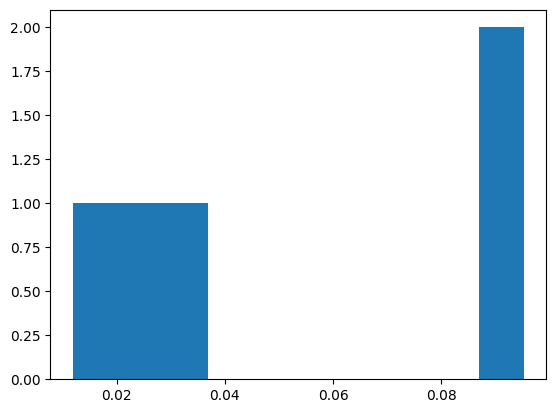

candidate: tensor([[0.4633, 0.0110, 0.0179]], dtype=torch.float64)
BO iteration:  5
Current best objective:  tensor(-0.0307, dtype=torch.float64)
loss to look for:  tensor([0.4633, 0.0110, 0.0179], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[0.8037420088888412, 0.701849609019999]
[0.0638921055956565, -0.4715552023019751]
[-0.6061794992278797, 0.979828392073766]
[-0.2935328241848498, -0.8755424339934355]
[0.5649075729767694, -0.3644739786655906]
[-0.4841020929136597, 0.20751058121013344]
[-0.5661735583314251, 0.43897792323326024]
[0.8855642851681957, -0.44216550375652197]
[-0.09291888510915691, 0.7693958399529068]
[-0.12377637959341992, 0.008651899301472588]
number to sample from all params:  5
[(0, 2, 2), (1, 0, 0), (2, 1, 2), (2, 0, 0), (0, 0, 0)]


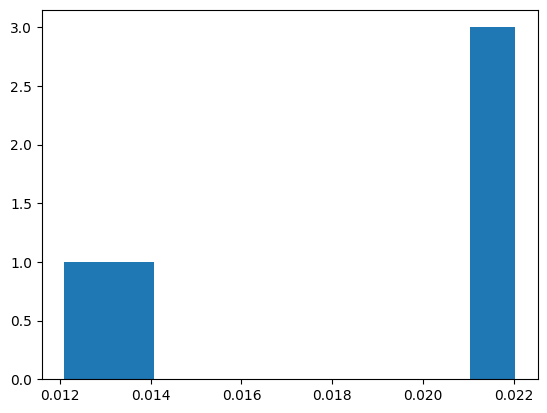

candidate: tensor([[0.4633, 0.0110, 0.0179]], dtype=torch.float64)
BO iteration:  6
Current best objective:  tensor(-0.0200, dtype=torch.float64)
loss to look for:  tensor([0.4633, 0.0110, 0.0179], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[0.5327482821497247, 0.48560787387010573]
[-0.8478172918646099, 0.774797333880314]
[0.09206055866558294, 0.5431296023125249]
[0.4086451542798657, 0.5109873575571775]
[0.03260644043307859, 0.5603249688109142]
[0.3389822561081084, 0.9855809167274041]
[0.4790060843299113, -0.7168980708510562]
[0.8048956448514171, 0.5157005466890903]
[-0.3598418619836041, 0.07684446085612229]
[0.14386189750786338, 0.07190796851696524]
number to sample from all params:  5
[(1, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (1, 1, 2)]


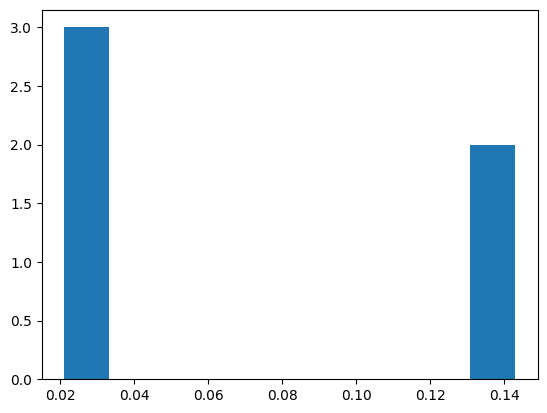

candidate: tensor([[0.4633, 0.0110, 0.0179]], dtype=torch.float64)
BO iteration:  7
Current best objective:  tensor(-0.0200, dtype=torch.float64)
loss to look for:  tensor([0.4633, 0.0110, 0.0179], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[-0.40981113460889906, 0.3307776782047396]
[0.18210538209631189, -0.8557268423261106]
[-0.409994521195554, 0.7274435324340651]
[0.3763475080585055, -0.34564532777432455]
[0.7839980374087483, -0.3050009301094061]
[0.3951763920413005, 0.2260287145929185]
[0.4434672732804612, -0.30724128026722153]
[0.5401668083856361, 0.795360864260972]
[-0.962797319732011, -0.738357479509659]
[-0.5195741326873626, -0.006536124201675708]
number to sample from all params:  5
[(0, 0, 2), (1, 1, 2), (1, 0, 2), (2, 1, 0), (0, 2, 0)]


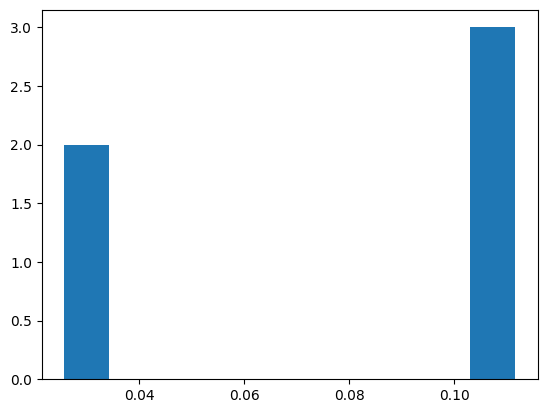

candidate: tensor([[0.4633, 0.0110, 0.0179]], dtype=torch.float64)
BO iteration:  8
Current best objective:  tensor(-0.0200, dtype=torch.float64)
loss to look for:  tensor([0.4633, 0.0110, 0.0179], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[-0.37165983777765965, 0.46664300212353993]
[0.14869783934959635, 0.22587166449426532]
[0.4323374748744284, -0.41762194500144223]
[0.5209442989846789, 0.029513925110954853]
[0.16186474462735623, 0.9944888704150032]
[-0.4565718193984962, -0.17541154175634333]
[-0.9071834835991541, -0.29259872376467944]
[0.4464267901331762, -0.5689108539186769]
[-0.7002396186903344, 0.44946810031566775]
[-0.3237938816144146, 0.6782134780297719]
number to sample from all params:  5
[(0, 1, 0), (0, 2, 0), (1, 0, 0), (1, 2, 0), (2, 2, 0)]


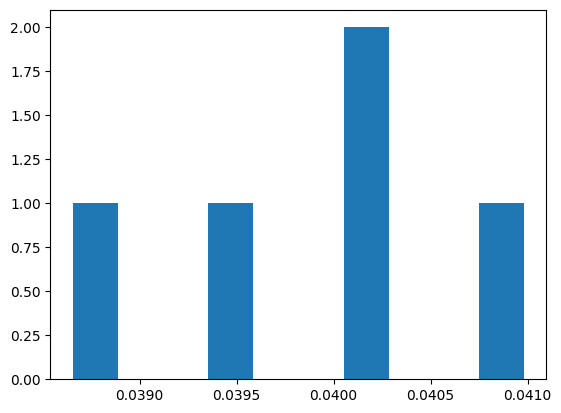

candidate: tensor([[0.4073, 0.0110, 0.0179]], dtype=torch.float64)
BO iteration:  9
Current best objective:  tensor(-0.0200, dtype=torch.float64)
loss to look for:  tensor([0.4073, 0.0110, 0.0179], dtype=torch.float64)


C:\Users\zhi liang\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[-0.544932849600384, -0.5398512540750422]
[0.6288504697969595, 0.38953835200750664]
[0.5196855542704195, 0.818549659061085]
[0.4254893653807905, 0.14513773695954613]
[0.8717439366122661, 0.6695896265887109]
[-0.06505189604590367, 0.5333793483800269]
[-0.9517820025610892, -0.32502614081859904]
[-0.49913453732399526, 0.4601142082877798]
[0.5916488837943645, -0.33031998198744983]
[-0.5966327944637528, -0.3280871177590876]
number to sample from all params:  5
[(1, 2, 1), (1, 0, 0), (0, 0, 0), (0, 0, 2), (0, 2, 1)]


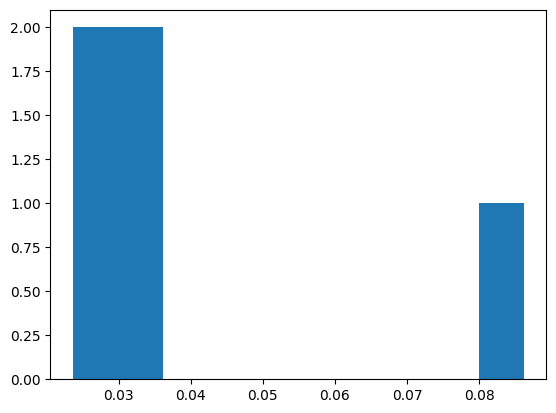

candidate: tensor([[0.4098, 0.0110, 0.0179]], dtype=torch.float64)


In [40]:
dg_nn.random_initialize_param()
# BO with local loss -> system loss
dg_nn.fit_locally_partial(50)

bounds = torch.tensor([np.array(lower_bound_local_loss), np.array(lower_bound_local_loss) * 5])
all_best_losses_ours, best_param = BO_graph_local_loss(dg_nn, bounds, "nn_lookup", iteration=10)